In [1]:

%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import vtk
import math

In [2]:
wellLoc = pd.read_csv('VNC_BH_Loc.csv',index_col=0)
wellLoc.head()

,X,Y,Z
Borehole,,,
NT-MW20-8,487379.258,5147487.331,298.70
NT-MW21-10,487396.729,5147463.826,297.29
NT-MW22-9,487367.603,5147577.135,297.68
NT-MW23-10,487390.523,5147661.184,297.13
NT-MW23-3,487391.089,5147658.747,297.13


In [3]:
wellLito = pd.read_csv('VNC_BH_Lith.csv',index_col=0)
wellLito.head()

,Borehole,X,Y,Z_Top,Z_Bot,Formation,hydrogeoCode
1,NT-MW20-8,487379.258,5147487.331,298.70,298.68,Organics,1
2,NT-MW20-8,487379.258,5147487.331,298.68,297.86,Sand/Silt/Till1,3
3,NT-MW20-8,487379.258,5147487.331,297.86,291.44,Bedrock,7
4,NT-MW21-10,487396.729,5147463.826,297.29,287.51,Bedrock,7
5,NT-MW22-9,487367.603,5147577.135,297.68,297.58,Organics,1


In [4]:
litoPoints = []

for index, values in wellLito.iterrows():
    wellX, wellY, wellZ = wellLoc.loc[values.Borehole][["X","Y","Z"]]
    wellXY = [wellX, wellY]
    litoPoints.append(wellXY + [values.Z_Top,values.hydrogeoCode])
    litoPoints.append(wellXY + [values.Z_Bot,values.hydrogeoCode])
    
    litoLength = values.Z_Top - values.Z_Bot
    if litoLength < 1:
        midPoint = wellXY + [values.Z_Top - litoLength/2,values.hydrogeoCode]
    else:
        npoints = int(litoLength)
        for point in range(1,npoints+1):
            disPoint = wellXY + [values.Z_Top - litoLength*point/(npoints+1),values.hydrogeoCode]
            litoPoints.append(disPoint)
litoNp=np.array(litoPoints)
np.save("litoNp",litoNp)
litoNp[:5]

array([[4.87379258e+05, 5.14748733e+06, 2.98700000e+02, 1.00000000e+00],
       [4.87379258e+05, 5.14748733e+06, 2.98680000e+02, 1.00000000e+00],
       [4.87379258e+05, 5.14748733e+06, 2.98680000e+02, 3.00000000e+00],
       [4.87379258e+05, 5.14748733e+06, 2.97860000e+02, 3.00000000e+00],
       [4.87379258e+05, 5.14748733e+06, 2.97860000e+02, 7.00000000e+00]])

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [6]:
litoX, litoY, litoZ = litoNp[:,0], litoNp[:,1], litoNp[:,2]
litoMean = litoNp[:,:3].mean(axis=0)
litoTrans = litoNp[:,:3]-litoMean
litoTrans[:5]

#setting up scaler
scaler = preprocessing.StandardScaler().fit(litoTrans)
litoScale = scaler.transform(litoTrans)

#check scaler
print(litoScale.mean(axis=0))
print(litoScale.std(axis=0))

[-1.79384635e-15  7.72163945e-16  1.18888073e-17]
[1. 1. 1.]


In [7]:
#run classifier
X = litoScale
Y = litoNp[:,3]
clf = MLPClassifier(activation='tanh',solver='lbfgs',hidden_layer_sizes=(30,30,30), max_iter=10000)
clf.fit(X,Y)

c:\Users\acgr9\miniconda3\envs\geomodel\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='tanh', hidden_layer_sizes=(30, 30, 30),
              max_iter=10000, solver='lbfgs')

In [8]:
numberSamples = litoNp.shape[0]
expected=litoNp[:,3]
predicted = []
for i in range(numberSamples):
    predicted.append(clf.predict([litoScale[i]]))
results = confusion_matrix(expected,predicted)
print(results)

[[  43    2   11    2    0    1    6]
 [   1   48    6    3    0    0    3]
 [   9    7  136    8    0    2   35]
 [   1    3   10  146   15    3    7]
 [   0    0    2   19   57    4   20]
 [   1    1    3    2    3   47   12]
 [   2    4   16    9   10    8 1735]]


In [9]:
xmin = 487028
xmax = 491162
ymin = 5144168
ymax = 5149592
zmax = int(wellLito.Z_Top.max())
zmin = zmax - 200

In [10]:
#If index error occurs while constructing lithologic matrix (line 180), try reducing these values to increase grid resolution.
#As mentioned above with regards to rounding, higher number of non-zero digits in coordinate values appears to coincide with greater required discretization to avoid index error.

cellH = 20
cellV = 10

In [11]:
vertexCols = np.arange(xmin,xmax+1,cellH)
vertexRows = np.arange(ymax,ymin-1,-cellH)
vertexLays = np.arange(zmax,zmin-1,-cellV)
cellCols = (vertexCols[1:]+vertexCols[:-1])/2
cellRows = (vertexRows[1:]+vertexRows[:-1])/2 
cellLays = (vertexLays[1:]+vertexLays[:-1])/2
nCols = cellCols.shape[0]
nRows = cellCols.shape[0]
nLays = cellLays.shape[0]

In [12]:
i=0
litoMatrix=np.zeros([nLays,nRows,nCols])
for lay in range(nLays):
    for row in range(nRows):
        for col in range(nCols):
            cellXYZ = [cellCols[col],cellRows[row],cellLays[lay]]
            cellTrans = cellXYZ - litoMean
            cellNorm = scaler.transform([cellTrans])
            
            litoMatrix[lay,row,col] = clf.predict(cellNorm)
            
            if i%30000==0:
                print("Processing %s cells"%i)
                print(cellTrans)
                print(cellNorm)
                print(litoMatrix[lay,row,col])
            i+=1

Processing 0 cells
[-1.20295168e+03  4.85808886e+04  2.29843423e+01]
[[-1.3802926   0.1046007   1.45609592]]
3.0
Processing 30000 cells
[1.39704832e+03 4.56808886e+04 2.29843423e+01]
[[1.60300324 0.09835664 1.45609592]]
4.0
Processing 60000 cells
[-1.22951685e+02  4.68808886e+04  1.29843423e+01]
[[-0.1410774   0.10094039  0.82257946]]
7.0
Processing 90000 cells
[2.47704832e+03 4.81008886e+04 2.98434227e+00]
[[2.84221844 0.1035672  0.189063  ]]
7.0
Processing 120000 cells
[9.57048315e+02 4.51808886e+04 2.98434227e+00]
[[1.09813779 0.09728008 0.189063  ]]
7.0
Processing 150000 cells
[-5.62951685e+02  4.63808886e+04 -7.01565773e+00]
[[-0.64594285  0.09986383 -0.44445347]]
7.0
Processing 180000 cells
[ 2.03704832e+03  4.76008886e+04 -1.70156577e+01]
[[ 2.33735299  0.10249064 -1.07796993]]
7.0
Processing 210000 cells
[ 5.17048315e+02  4.46808886e+04 -1.70156577e+01]
[[ 0.59327234  0.09620352 -1.07796993]]
7.0
Processing 240000 cells
[-1.00295168e+03  4.58808886e+04 -2.70156577e+01]
[[-1.150

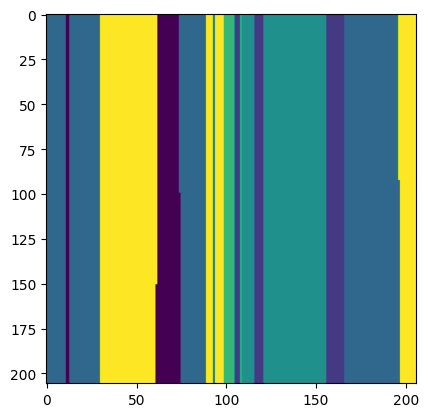

In [13]:
plt.imshow(litoMatrix[0])

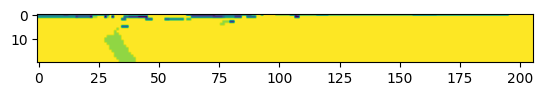

In [14]:
plt.imshow(litoMatrix[:,20])

In [15]:
np.save('litoMatrix',litoMatrix)

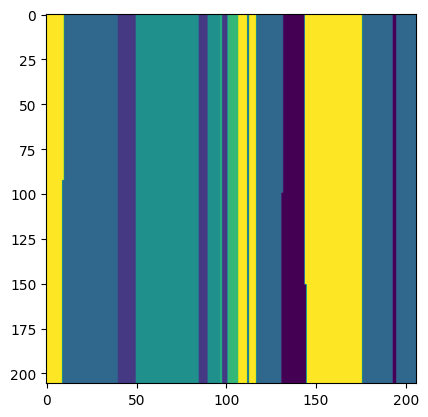

In [16]:
#matrix modification for Vtk representation
litoMatrixMod = litoMatrix[:,:,::-1]
np.save('litoMatrixMod',litoMatrixMod)
plt.imshow(litoMatrixMod[0])

In [17]:
# Create empty grid
grid = pv.RectilinearGrid()

In [18]:
# Initialize from a vtk.vtkRectilinearGrid object
vtkgrid = vtk.vtkRectilinearGrid()
grid = pv.RectilinearGrid(vtkgrid)
grid = pv.RectilinearGrid(vertexCols,vertexRows,vertexLays)

In [20]:
#litoFlat = list(litoMatrixMod.flatten(order="K"))[::-1]
#grid.cell_arrays["hydrogeoCode"] = np.array(litoFlat)
#grid.save('hydrogeologicalUnit.vtk')